## Proof of concept for Beta conjugated Markov Chain for post-cat trade

![trade_MC](../docs/trade_MC.png)

In [9]:
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import beta

# Initial Markov Chain----
# Trade -> Trade 001
# Not Trade -> Trade 001
# Trade -> Not Trade 099
# Not Trade -> Not Trade 099

# Trade -> External Trade 001
# Not Trade -> External Trade 001
# Trade -> External Not Trade 099
# Not Trade -> External Not Trade 099

initial_MC = np.array([[0.01, 0.01], [0.99, 0.99],
                       [0.01, 0.01], [0.99, 0.99]])

# Target Markov Chain----
# Trade -> Trade 09
# Not Trade -> Trade 07
# Trade -> Not Trade 01
# Not Trade -> Not Trade 03

# Trade -> External Trade 08
# Not Trade -> External Trade 06
# Trade -> Externak Not Trade 02
# Not Trade -> External Not Trade 04

target_MC = np.array([[0.9, 0.7], [0.1, 0.3],
                      [0.8, 0.6], [0.2, 0.4]])

T = 20
#T = 3653 # Number of timesteps, iterated daily for 10 years
#T = 87660 # Number of timesteps, iterated hourly for 10 years

def relaxed_sigmoid(x):
    return 1.0 / (1.0 + np.exp(0.5*-x))

for t in range(T):
  # Initialise an empty zero matrix in the shape of target_MC
  trans_mat = np.zeros_like(target_MC)

  lr = 0.01 * (t+1 - 1/T)  # increase learning rate, simulate trade amelioration

  if t == 0:
    # Beta  for Trade -> Trade and No Trade
    trans_mat[0, 0] = beta(initial_MC[0, 0]*100+1, (1-initial_MC[0, 0])*100+1).mean()+0.0001
    trans_mat[1, 0] = 1 - trans_mat[0, 0]

    # Beta  for No Trade -> Trade and No Trade
    trans_mat[0, 1] = beta(initial_MC[0, 1]*100+1, (1-initial_MC[0, 1])*100+1).mean()+0.0001
    trans_mat[1, 1] = 1 - trans_mat[0, 1]

    # Beta  for Trade -> External Trade and External No Trade
    trans_mat[2, 0] = beta(initial_MC[2, 0]*100+1, (1-initial_MC[2, 0])*100+1).mean()+0.0001
    trans_mat[3, 0] = 1 - trans_mat[2, 0]

    # Beta  for No Trade -> External Trade and External No Trade
    trans_mat[2, 1] = beta(initial_MC[2, 1]*100+1, (1-initial_MC[2, 1])*100+1).mean()+0.0001
    trans_mat[3, 1] = 1 - trans_mat[2, 1]

    #Set up ELEMENT-WISE loss function, nudge towards target
    E = (trans_mat - target_MC)
    trans_mat = trans_mat - (E * lr)
    #trans_mat = relaxed_sigmoid(trans_mat)

    # Brute-force markov chain rule Trade / 1-Trade
    trans_mat[1, 0] = 1 - trans_mat[0, 0]
    trans_mat[1, 1] = 1 - trans_mat[0, 1]
    trans_mat[3, 0] = 1 - trans_mat[2, 0]
    trans_mat[3, 1] = 1 - trans_mat[2, 1]

    prev_trans_mat = trans_mat

  else:
    # There's a bug here, where when the trans_mat generated very very small
    # float numbers, beta goes out of wack e.g. [854994678e-122, 100000000e+000]

    trans_mat[0, 0] = beta(prev_trans_mat[0, 0]*100+1, (1-prev_trans_mat[0, 0])*100+1).mean()+0.0001
    trans_mat[1, 0] = 1 - trans_mat[0, 0]

    trans_mat[0, 1] = beta(prev_trans_mat[0, 1]*100+1, (1-prev_trans_mat[0, 1])*100+1).mean()+0.0001
    trans_mat[1, 1] = 1 - trans_mat[0, 1]

    trans_mat[2, 0] = beta(prev_trans_mat[2, 0]*100+1, (1-prev_trans_mat[2, 0])*100+1).mean()+0.0001
    trans_mat[3, 0] = 1 - trans_mat[2, 0]

    trans_mat[2, 1] = beta(prev_trans_mat[2, 1]*100+1, (1-prev_trans_mat[2, 1])*100+1).mean()+0.0001
    trans_mat[3, 1] = 1 - trans_mat[2, 1]

    # Set up ELEMENT-WISE loss function, nudge towards target
    # Using Error instead of Squared Error since its ELEMENT-WISE
    E = (trans_mat - target_MC)
    trans_mat = trans_mat - (E * lr)

    #trans_mat = relaxed_sigmoid(trans_mat)

    # Brute-force markov chain rule Trade / 1-Trade
    trans_mat[1, 0] = 1 - trans_mat[0, 0]
    trans_mat[1, 1] = 1 - trans_mat[0, 1]
    trans_mat[3, 0] = 1 - trans_mat[2, 0]
    trans_mat[3, 1] = 1 - trans_mat[2, 1]

    prev_trans_mat = trans_mat

  print(prev_trans_mat)

[[0.02807062 0.02617062]
 [0.97192938 0.97382938]
 [0.02712062 0.02522062]
 [0.97287938 0.97477938]]
[[0.05424437 0.04851794]
 [0.94575563 0.95148206]
 [0.05138115 0.04565473]
 [0.94861885 0.95434527]]
[[0.08777367 0.07642515]
 [0.91222633 0.92357485]
 [0.08209941 0.07075089]
 [0.91790059 0.92924911]]
[[0.12771626 0.10912974]
 [0.87228374 0.89087026]
 [0.118423   0.09983647]
 [0.881577   0.90016353]]
[[0.1729777  0.14575761]
 [0.8270223  0.85424239]
 [0.15936766 0.13214757]
 [0.84063234 0.86785243]]
[[0.22236025 0.18536173]
 [0.77763975 0.81463827]
 [0.20386099 0.16686247]
 [0.79613901 0.83313753]]
[[0.27461483 0.22696275]
 [0.72538517 0.77303725]
 [0.25078879 0.2031367 ]
 [0.74921121 0.7968633 ]]
[[0.32849298 0.26958931]
 [0.67150702 0.73041069]
 [0.29904115 0.24013748]
 [0.70095885 0.75986252]]
[[0.38279582 0.31231563]
 [0.61720418 0.68768437]
 [0.34755572 0.27707553]
 [0.65244428 0.72292447]]
[[0.43641714 0.35429419]
 [0.56358286 0.64570581]
 [0.39535567 0.31323271]
 [0.60464433 0.6

## Single sample

In [10]:
initial_MC = np.array([[0.01, 0.01], [0.99, 0.99],
                       [0.01, 0.01], [0.99, 0.99]])

target_MC = np.array([[0.9, 0.7], [0.1, 0.3],
                      [0.8, 0.6], [0.2, 0.4]])

# Trade -> Trade 0.9
# Trade -> No_Trade 0.1
print(f"trade -> trade:{target_MC[0, 0]}")
print(f"trade -> no_trade:{target_MC[1, 0]}")

# No Trade -> Trade 0.7
# No Trade -> No Trade 0.3
print(f"no_trade -> trade:{target_MC[0, 1]}")
print(f"no_trade -> no trade:{target_MC[1, 1]}")

# Trade -> External Trade 0.8
# Trade -> External No Trade 0.2
print(f"trade -> external_trade:{target_MC[2, 0]}")
print(f"trade -> no_external_trade:{target_MC[3, 0]}")

# No Trade -> External Trade 0.6
# No Trade -> External No Trade 0.4
print(f"no_trade -> external_trade:{target_MC[2, 1]}")
print(f"no_trade -> no_external_trade:{target_MC[3, 1]}")

trade -> trade:0.9
trade -> no_trade:0.1
no_trade -> trade:0.7
no_trade -> no trade:0.3
trade -> external_trade:0.8
trade -> no_external_trade:0.2
no_trade -> external_trade:0.6
no_trade -> no_external_trade:0.4


In [11]:
# Single sample
# Initial Trade -> Trade 0.01
# Initial Trade -> No Trade 0.99

alpha_ = beta(initial_MC[0, 0]*100+1, (1-initial_MC[0, 0])*100+1).mean()
beta_ = 1-alpha_

transition = np.array([alpha_, beta_])
target_array = np.array([target_MC[0, 0], target_MC[1, 0]])

E = (transition - target_array)

print(f"initial MC = {initial_MC[0, 0], initial_MC[1, 0]}")
print(f"target_array = {target_array}")
print(f"transition matrix = {transition}")
print(f"Error = {E}")

def relaxed_sigmoid(x):
    return 1.0 / (1.0 + np.exp(0.5*-x))

transition = transition - (E * 0.1)

# Brute-force markov chain rule Trade / 1-Trade
transition[1] = 1 - transition[0]

print(f"output transitiion = {transition}")
#print(f"sigmoid transition = {relaxed_sigmoid(transition)}")

initial MC = (0.01, 0.99)
target_array = [0.9 0.1]
transition matrix = [0.01960784 0.98039216]
Error = [-0.88039216  0.88039216]
output transitiion = [0.10764706 0.89235294]


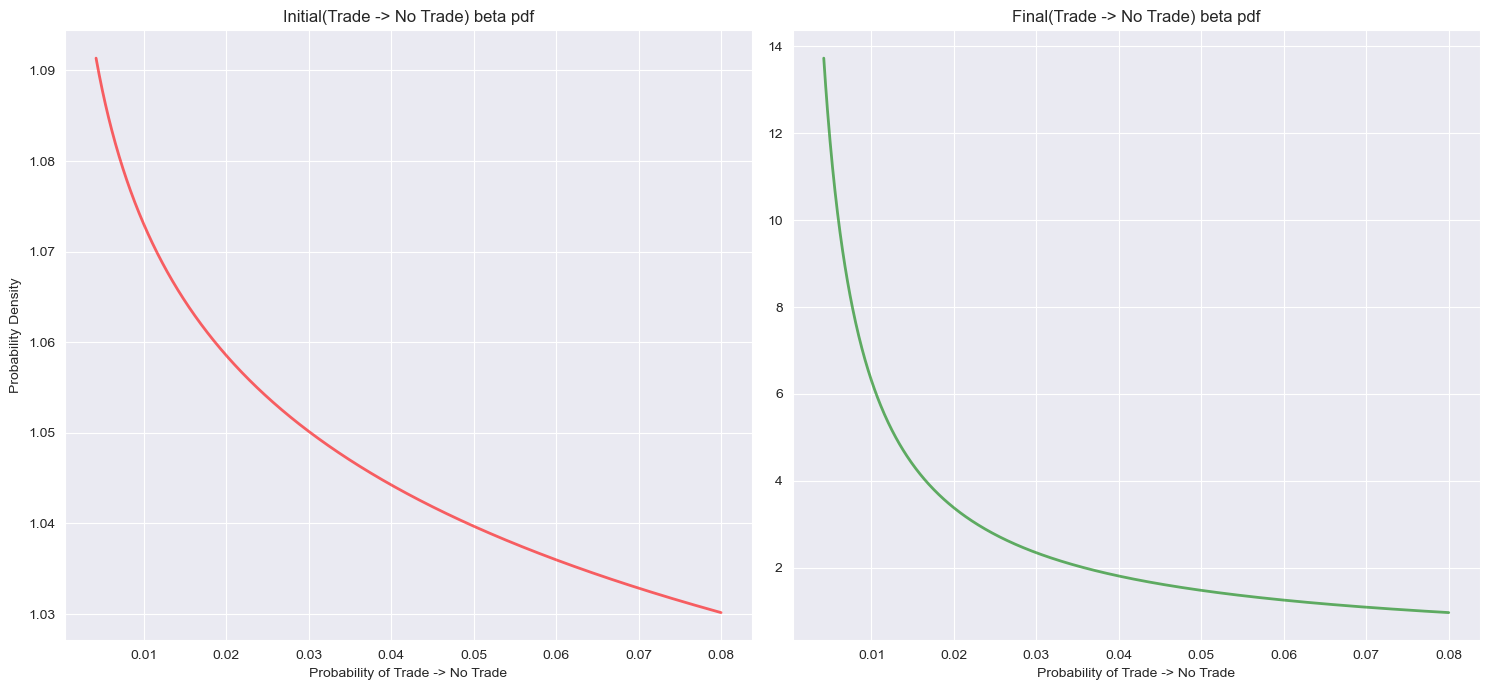

In [12]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(1, 2, figsize = (15, 7), sharey = False)

x = np.linspace(beta.ppf(0.01, alpha_*100+1, (1-alpha_)*100+1),
                beta.ppf(0.99, alpha_*100+1, (1-alpha_)*100+1), 1000)

ax[0].plot(x, beta.pdf(x, beta_, 1),'r-', lw=2, alpha=0.6)
ax[0].set_title('Initial(Trade -> No Trade) beta pdf')
ax[1].plot(x, beta.pdf(x, 0.1, 1), "g-", lw=2, alpha=0.6)
ax[1].set_title('Final(Trade -> No Trade) beta pdf')

ax[0].set_ylabel("Probability Density")
ax[0].set_xlabel("Probability of Trade -> No Trade")
ax[1].set_xlabel("Probability of Trade -> No Trade")

fig.tight_layout()
plt.show()